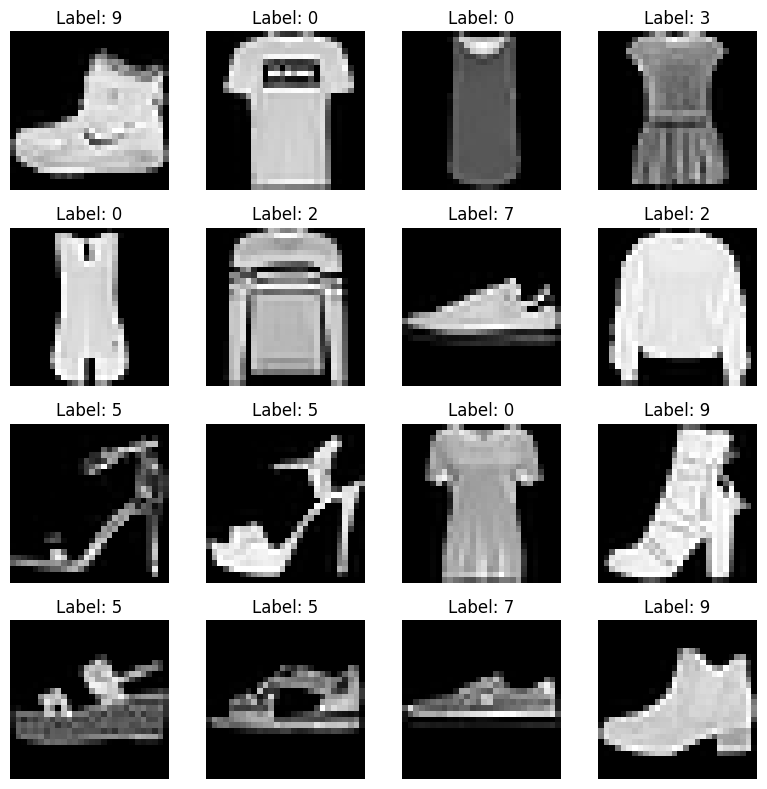

In [1]:
import matplotlib.pyplot as plt

import torchvision.transforms as transforms

from FashionMNIST import FashionMNIST

train_dataset = FashionMNIST("./FashionMNIST", 
                             train=True, 
                             transform=transforms.ToTensor(), 
                             download=True,
                             )
test_dataset = FashionMNIST("./FashionMNIST", 
                            train=False, 
                            transform=transforms.ToTensor(), 
                            download=True,
                            )

# Create a subplot with 4x4 grid
fig, axs = plt.subplots(4, 4, figsize=(8, 8))

# Loop through each subplot and plot an image
for i in range(4):
    for j in range(4):
        image, label = train_dataset[i * 4 + j]  # Get image and label
        image_numpy = image.numpy().squeeze()    # Convert image tensor to numpy array
        axs[i, j].imshow(image_numpy, cmap='gray')  # Plot the image
        axs[i, j].axis('off')  # Turn off axis
        axs[i, j].set_title(f"Label: {label}")  # Set title with label

plt.tight_layout()  # Adjust layout
plt.show()  # Show plot

In [2]:
import torch
import torch.nn as nn


class Unet_diffuser(nn.Module):
    def __init__(self):
        super(Unet_diffuser, self).__init__()
        self.conv1 = nn.Sequential(nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1),
                                nn.ReLU(),
                                nn.BatchNorm2d(32),
        )
        self.conv2 = nn.Sequential(nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
                                nn.ReLU(),
                                nn.BatchNorm2d(64),
        )
        self.conv3 = nn.Sequential(nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
                                nn.ReLU(),
                                nn.BatchNorm2d(128),
        )
        
        self.time_mlp = nn.Sequential(nn.Linear(16, 64),
                                      nn.ReLU(),
                                      nn.Linear(64, 128*4*4),
                                      )
        
        self.deconv1 = nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1)
        self.deconv2 = nn.ConvTranspose2d(128, 32, kernel_size=3, stride=2, output_padding=1, padding=1)
        self.deconv3 = nn.ConvTranspose2d(64, 1, kernel_size=3, stride=2, output_padding=1, padding=1)

    def forward(self, x, t_embedding):
        x_conv1 = self.conv1(x)
        x_conv2 = self.conv2(x_conv1)
        x_conv3 = self.conv3(x_conv2)
        
        time_embedding = self.time_mlp(t_embedding)
        x_conv3 = x_conv3.view(-1, 128*4*4) + time_embedding
        x_conv3 = x_conv3.view(-1, 128, 4, 4)
        
        x_deconv1 = self.deconv1(x_conv3)
        x_deconv2 = self.deconv2(torch.concat([x_conv2, x_deconv1], dim=1))
        x_deconv3 = self.deconv3(torch.concat([x_conv1, x_deconv2], dim=1))
        
        return x_deconv3
    
class fashionmnist_classifier(nn.Module):
    def __init__(self):
        super(fashionmnist_classifier, self).__init__()
        self.conv = nn.Sequential(nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1),
                                nn.ReLU(),
                                nn.BatchNorm2d(32),
                                nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
                                nn.ReLU(),
                                nn.BatchNorm2d(64),
                                nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
                                nn.ReLU(),
                                nn.BatchNorm2d(128),
        )
        
        self.fc = nn.Sequential(nn.Linear(4*4*128, 32),
                                nn.ReLU(),
                                nn.Linear(32, 10))

    def forward(self, x):
        x = self.conv(x).view(-1, 4*4*128)
        output = self.fc(x)
                
        return output
    
        

In [9]:
import tqdm

import torch
import torch.optim as optim
from torch.utils.data import DataLoader

import wandb

wandb_config = {"learning_rate": 1e-3,
                "batch_size": 16,
                "epochs": 10,
                }

# wandb.init(
#     # set the wandb project where this run will be logged
#     project="conditional_DDIM",
#     # track hyperparameters and run metadata
#     config=wandb_config,
# )

device = "cuda" if torch.cuda.is_available() else "cpu"

train_dataloader = DataLoader(train_dataset, 
                              batch_size=wandb_config["batch_size"], 
                              shuffle=True,
                              )

diffuser = Unet_diffuser()
classifier = fashionmnist_classifier()

diffuser.to(device)
classifier.to(device)

classifier_optimizer = optim.SGD(classifier.parameters(), 
                      lr=wandb_config["learning_rate"], 
                      momentum=0.9, 
                      weight_decay=1e-5,
                      )

diffuser_optimizer = optim.SGD(diffuser.parameters(), 
                      lr=wandb_config["learning_rate"], 
                      momentum=0.9, 
                      weight_decay=1e-5,
                      )

# Training loop
diffuser_loss_fun = nn.MSELoss()
classifier_loss_fun = nn.CrossEntropyLoss()

total_step = 50
embedding_fun = nn.Embedding(total_step, embedding_dim=16).to(device)
beta = 1e-3
total_diffuser_loss = []
total_classifier_loss = []
for epoch in range(wandb_config["epochs"]):
    diffuser.train()
    classifier.train()
    
    train_loss = 0
    for batch_idx, (image, target) in enumerate(tqdm.tqdm(train_dataloader, total=len(train_dataloader))):
        classifier_optimizer.zero_grad()
        diffuser_optimizer.zero_grad()
        
        epsilon = torch.rand(image.size()).to(device)
        x0 = image.to(device)
        
        t = torch.randint(low=0, high=total_step, size=(1, )).to(device)
        
        t_embedding = embedding_fun(t)
        
        alpha_t_bar = (1-beta)**t
        diffuser_loss = diffuser_loss_fun(epsilon, diffuser(torch.sqrt(alpha_t_bar) * x0 + torch.sqrt(1 - alpha_t_bar)*epsilon, t_embedding))
        
        output = classifier(x0)
        classifier_loss = classifier_loss_fun(output, target.to(device))
        
        diffuser_loss.backward()
        classifier_loss.backward()

        classifier_optimizer.step()
        diffuser_optimizer.step()
        
        # wandb.log({"diffusion loss": diffuser_loss, "classifier loss": classifier_loss})
        total_diffuser_loss.append(diffuser_loss.detach().cpu().numpy())
        total_classifier_loss.append(classifier_loss.detach().cpu().numpy())
        
torch.save(classifier.state_dict(), "classifier.pt")
torch.save(diffuser.state_dict(), "diffuser.pt")
        
        

100%|██████████| 3750/3750 [01:00<00:00, 62.42it/s]


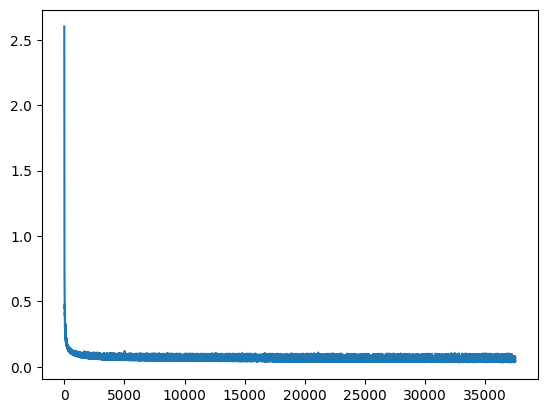

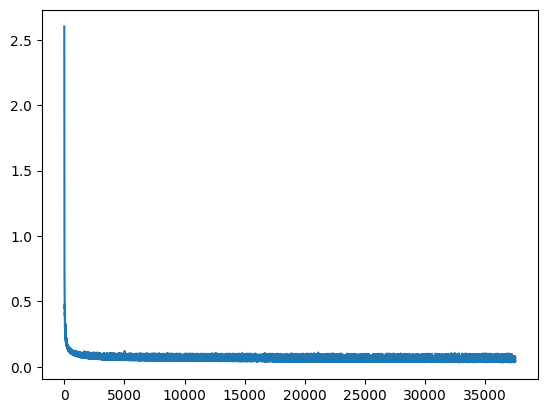

In [10]:
plt.figure()
plt.plot(range(len(total_diffuser_loss)), total_diffuser_loss)
plt.figure()
plt.plot(range(len(total_diffuser_loss)), total_diffuser_loss)

C:\Users\mengl\AppData\Local\Temp\ipykernel_44572\3750610010.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  diffuser.load_state_dict(torch.load("diffuser.pt"))
C:\Users

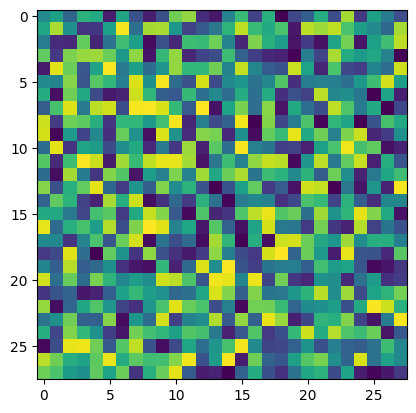

In [11]:
import numpy as np

x_t = torch.rand((1, 1, 28, 28)).to(device)

diffuser = Unet_diffuser()
classifier = fashionmnist_classifier()

diffuser.load_state_dict(torch.load("diffuser.pt"))
classifier.load_state_dict(torch.load("classifier.pt"))

diffuser.to(device)
classifier.to(device)

classifier_loss_fun = nn.CrossEntropyLoss()
for t in range(total_step, 1):
    classifier.eval()
    alpha_t_bar = (1-beta)**t
    
    input = x_t.copy()
    input.require_grad = True
    output = classifier.forward(input)
    classifier_loss = classifier_loss_fun(output, torch.ones((1, )).to(device))
    
    # backpropegate output gradient to input
    classifier_loss.backward(retain_graph=True)
    gradient = input.grad
    epsilon_hat = diffuser(x_t, embedding_fun(t)) - torch.sqrt(1 - alpha_t_bar)*gradient
    
    x_t = (1-beta)**(t-1) * (x_t - torch.sqrt(1 - alpha_t_bar)*epsilon_hat/torch.sqrt(alpha_t_bar)) + torch.sqrt(1 - (1-beta)**(t-1))*epsilon_hat

plt.tight_layout()  # Adjust layout
plt.imshow(np.squeeze(x_t.detach().cpu().numpy()))  # Show plot